# Read KNMI observations using hydropandas

This notebook introduces how to use the `hydropandas` package to read, process and visualise KNMI data.

Martin & Onno - 2022

## <a id=top></a>Notebook contents

1. [Observation types](#Obs)
2. [Get KNMI data](#reading)
3. [Get ObsCollections](#readingOC)
4. [Precipitation data](#precipitation)
5. [Reference evaporation types](#EvapRef)
6. [Spatial interpolation of evaporation](#EvapInterp)

In [1]:
import hydropandas as hpd
from hydropandas.io import io_knmi
from IPython.display import display

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import RBFInterpolator, NearestNDInterpolator

import logging
import time

In [2]:
hpd.util.get_color_logger('INFO');

## [Observation types](#top)<a id=Obs></a>

The hydropandas package has a function to read all kinds of KNMI observations. These are stored in an `Obs` object. There are three types of observations you can obtain from the KNMI:
- `EvaporationObs`, for evaporation time series
- `PrecipitationObs`, for precipitation time series
- `MeteoObs`, for all the other meteorological time series

With the code below we get the Evaporation in [m/day] for KNMI station 344 (Rotterdam Airport).

INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 344-ROTTERDAM between 2022-01-01 00:00:00 and 2023-01-09 16:38:12.025450
INFO:hydropandas.io.io_knmi:station 344 has 0 missing measurements


,EV24
2022-01-01 01:00:00,0.0003
2022-01-02 01:00:00,0.0003
2022-01-03 01:00:00,0.0002
2022-01-04 01:00:00,0.0002
2022-01-05 01:00:00,0.0001


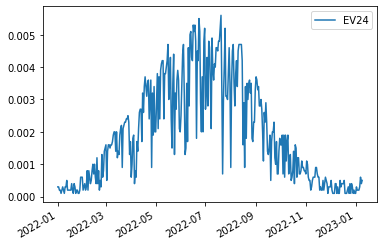

In [3]:
o = hpd.EvaporationObs.from_knmi(344)
display(o.head())
o.plot();

INFO:hydropandas.io.io_knmi:transform RH, Etmaalsom van de neerslag (in 0.1 mm) (0 voor <0.05mm) / Daily precipitation amount (in 0.1 mm) (0 for <0.05mm) lower than 0.05 mm to 0 mm
INFO:hydropandas.io.io_knmi:last RH measurement available at the Bilt is from 2023-01-10
INFO:hydropandas.io.io_knmi:assuming no RH measurements are available at other stations after this date
INFO:hydropandas.io.io_knmi:changing end_date to 2023-01-09
INFO:hydropandas.io.io_knmi:download knmi RH data from station 344-ROTTERDAM between 2022-01-01 00:00:00 and 2023-01-09 16:38:12.540876
INFO:hydropandas.io.io_knmi:transform RH, Etmaalsom van de neerslag (in 0.1 mm) (0 voor <0.05mm) / Daily precipitation amount (in 0.1 mm) (0 for <0.05mm) lower than 0.05 mm to 0 mm
INFO:hydropandas.io.io_knmi:station 344 has 0 missing measurements


,RH
2022-01-01 01:00:00,0.0000
2022-01-02 01:00:00,0.0002
2022-01-03 01:00:00,0.0064
2022-01-04 01:00:00,0.0000
2022-01-05 01:00:00,0.0008


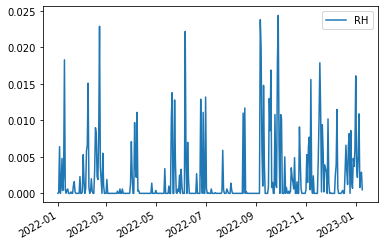

In [4]:
o = hpd.PrecipitationObs.from_knmi(344)
display(o.head())
o.plot();

**attributes**

A `MeteoObs` object has the following attributes:

* `name`: station name and variable
* `x`: x-coördinate in m RD
* `y`: y-coördinate in m RD
* `station`: station number
* `meta`: dictionary with other metadata

In [5]:
print(f"name: {o.name}")
print(f"x,y: {(o.x, o.y)}")
print(f"station: {o.station}")
print("metadata:")
for key, item in o.meta.items():
    print(f'    {key}: {item}')

name: RH_ROTTERDAM
x,y: (90598.0, 442813.0)
station: 344
metadata:
    LON_east: {'344': 4.447}
    LAT_north: {'344': 51.962}
    ALT_m: {'344': -4.3}
    NAME: {'344': 'Rotterdam'}
    RH: Etmaalsom van de neerslag (in m) (0 voor <0.05mm) / Daily precipitation amount (in m) (0 for <0.05mm)
    x: 90598.0
    y: 442813.0
    station: 344
    name: RH_ROTTERDAM
    source: KNMI


## [Get KNMI data](#top)<a id=reading></a>

There are 2 main method to obtain meteorological data:

1. `from_knmi`
2. `from_nearest_xy`

Below you can see how they can be called to obtain the precipitation data. Notice that they return the same data because station 344 is nearest to the given xy coördinates.

In [6]:
o1 = hpd.PrecipitationObs.from_knmi(344)
o2 = hpd.PrecipitationObs.from_nearest_xy((90600, 442800))
o1.equals(o2)

INFO:hydropandas.io.io_knmi:transform RH, Etmaalsom van de neerslag (in 0.1 mm) (0 voor <0.05mm) / Daily precipitation amount (in 0.1 mm) (0 for <0.05mm) lower than 0.05 mm to 0 mm
INFO:hydropandas.io.io_knmi:last RH measurement available at the Bilt is from 2023-01-10
INFO:hydropandas.io.io_knmi:assuming no RH measurements are available at other stations after this date
INFO:hydropandas.io.io_knmi:changing end_date to 2023-01-09
INFO:hydropandas.io.io_knmi:download knmi RH data from station 344-ROTTERDAM between 2022-01-01 00:00:00 and 2023-01-09 16:38:13.337885
INFO:hydropandas.io.io_knmi:transform RH, Etmaalsom van de neerslag (in 0.1 mm) (0 voor <0.05mm) / Daily precipitation amount (in 0.1 mm) (0 for <0.05mm) lower than 0.05 mm to 0 mm
INFO:hydropandas.io.io_knmi:station 344 has 0 missing measurements
INFO:hydropandas.io.io_knmi:transform RH, Etmaalsom van de neerslag (in 0.1 mm) (0 voor <0.05mm) / Daily precipitation amount (in 0.1 mm) (0 for <0.05mm) lower than 0.05 mm to 0 mm
I

True

**read options**

The `MeteoObs.from_knmi` method contains the following keyword arguments:

- `stn`: station number.
- `startdate`: the start date of the time series you want, default is 1st of January 2019.
- `enddate`: the end date of the time series you want, default is today.
- `fill_missing_obs`: option to fill missing values with values from the nearest KNMI station. If measurements are filled an extra column is added to the time series in which the station number is shown that was used to fill a particular missing value.
- `interval`: time interval of the time series, default is 'daily'
- `raise_exception`: option to raise an error when the requested time series is empty.
***

The 3 examples below give a brief summary of these options

INFO:hydropandas.io.io_knmi:download knmi TG data from station 344-ROTTERDAM between 1960-01-01 00:00:00 and 2023-01-09 16:38:14.201992
INFO:hydropandas.io.io_knmi:station 344 has 2 missing measurements
INFO:hydropandas.io.io_knmi:trying to fill 2 measurements with station [215]
INFO:hydropandas.io.io_knmi:download knmi TG data from station 215-VOORSCHOTEN between 1960-01-01 00:00:00 and 2023-01-09 16:38:14.201992
INFO:hydropandas.io.io_knmi:trying to fill 2 measurements with station [210]
INFO:hydropandas.io.io_knmi:download knmi TG data from station 210-VALKENBURG between 1960-01-01 00:00:00 and 2023-01-09 16:38:14.201992


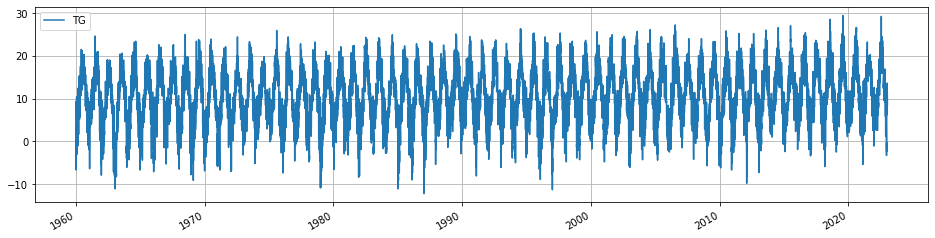

In [7]:
#example 1 get daily average temperature from 1900 till now
o_t = hpd.MeteoObs.from_knmi(344, 'TG', startdate='1960')
o_t.plot(figsize=(16,4), grid=True);

INFO:hydropandas.io.io_knmi:download knmi RD data from station 892-GIERSBERGEN between 1972-01-01 00:00:00 and 2023-01-09 16:38:16.698110
INFO:hydropandas.io.io_knmi:last RD measurement available at the Bilt is from 2022-12-10
INFO:hydropandas.io.io_knmi:assuming no RD measurements are available at other stations after this date
INFO:hydropandas.io.io_knmi:changing end_date to 2022-12-10
INFO:hydropandas.io.io_knmi:download knmi RD data from station 892-GIERSBERGEN between 1972-01-01 00:00:00 and 2022-12-10 09:00:00
INFO:hydropandas.io.io_knmi:station 892 has no measurements before 1993-11-01 09:00:00
INFO:hydropandas.io.io_knmi:station 892 has 7975 missing measurements
INFO:hydropandas.io.io_knmi:trying to fill 7975 measurements with station [910]
INFO:hydropandas.io.io_knmi:download knmi RD data from station 910-AMMERZODEN between 1972-01-01 00:00:00 and 2022-12-10 09:00:00


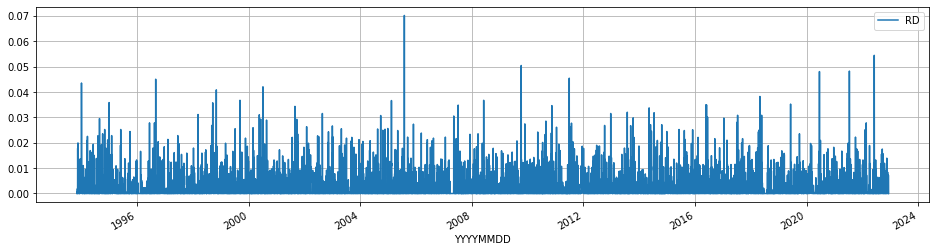

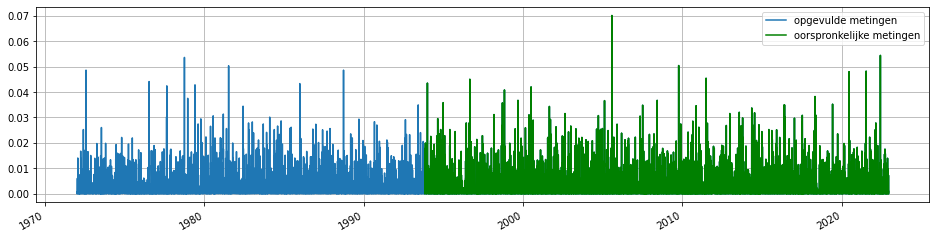

In [8]:
#example 2 get daily average precipitation from 1972 with and without filling missing measurements
o_rd = hpd.PrecipitationObs.from_knmi(892, stn_type='precipitation', startdate='1972', fill_missing_obs=False)
o_rd.plot(figsize=(16,4), grid=True)

o_rd_filled = hpd.PrecipitationObs.from_knmi(892, stn_type='precipitation', startdate='1972', fill_missing_obs=True)
fig, ax = plt.subplots()
o_rd_filled['RD'].plot(figsize=(16,4), ax=ax, label='opgevulde metingen');
o_rd_filled.loc[o_rd_filled['station_opvulwaarde'].isna(),'RD'].plot(color='green',ax=ax,grid=True,  label='oorspronkelijke metingen');
ax.legend();

In [9]:
#see the station_opvulwaarde
display(o_rd.head())
display(o_rd_filled.head())

,RD
YYYYMMDD,
1993-11-01 09:00:00,0.0000
1993-11-02 09:00:00,0.0000
1993-11-03 09:00:00,0.0005
1993-11-04 09:00:00,0.0000
1993-11-05 09:00:00,0.0000


,RD,station_opvulwaarde
1972-01-01 09:00:00,0.0000,910
1972-01-02 09:00:00,0.0000,910
1972-01-03 09:00:00,0.0000,910
1972-01-04 09:00:00,0.0000,910
1972-01-05 09:00:00,0.0004,910


In [10]:
# example 3 get evaporation and print additional information during download using the logging module
logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.INFO)

o_ev = hpd.EvaporationObs.from_knmi(344, startdate='1972', fill_missing_obs=True)
o_ev

INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 344-ROTTERDAM between 1972-01-01 00:00:00 and 2023-01-09 16:38:20.747955
INFO:hydropandas.io.io_knmi:station 344 has no measurements before 1987-09-12 01:00:00
INFO:hydropandas.io.io_knmi:station 344 has 5809 missing measurements
INFO:hydropandas.io.io_knmi:trying to fill 5809 measurements with station [215]
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 215-VOORSCHOTEN between 1972-01-01 00:00:00 and 2023-01-09 16:38:20.747955
INFO:hydropandas.io.io_knmi:trying to fill 5809 measurements with station [210]
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 210-VALKENBURG between 1972-01-01 00:00:00 and 2023-01-09 16:38:20.747955
INFO:hydropandas.io.io_knmi:trying to fill 5563 measurements with station [330]
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 330-HOEK-VAN-HOLLAND between 1972-01-01 00:00:00 and 2023-01-09 16:38:20.747955
INFO:hydropandas.io.io_knmi:trying to fil

,EV24,station_opvulwaarde
1972-01-01 01:00:00,0.0002,260
1972-01-02 01:00:00,0.0002,260
1972-01-03 01:00:00,0.0002,260
1972-01-04 01:00:00,0.0000,260
1972-01-05 01:00:00,0.0000,260
...,...,...
2023-01-05 01:00:00,0.0002,NaN
2023-01-06 01:00:00,0.0003,NaN
2023-01-07 01:00:00,0.0006,NaN
2023-01-08 01:00:00,0.0004,NaN


In [11]:
# reset the logging module
logging.getLogger().setLevel(logging.ERROR)

## [Get ObsCollections](#top)<a id=readingOC></a>

It is also possible to read multiple `Observation` objects at once and store them in an `ObsCollection` object. For this we use the `ObsCollection.from_knmi()` method. Below an example to obtain precipitation (RH) and evaporation (EV24) from the KNMI station of Rotterdam and De Bilt. 

In [12]:
oc = hpd.read_knmi(stns=[344, 260], meteo_vars=['RH', 'EV24'])
oc

,x,y,filename,source,station,meteo_var,obs
name,,,,,,,
RH_ROTTERDAM,90598.000000,442813.000000,,KNMI,344,RH,PrecipitationObs RH_ROTTERDAM -----metadata---...
RH_DE-BILT,141002.996557,456772.017696,,KNMI,260,RH,PrecipitationObs RH_DE-BILT -----metadata-----...
EV24_ROTTERDAM,90598.000000,442813.000000,,KNMI,344,EV24,EvaporationObs EV24_ROTTERDAM -----metadata---...
EV24_DE-BILT,141002.996557,456772.017696,,KNMI,260,EV24,EvaporationObs EV24_DE-BILT -----metadata-----...


Besides giving a list of stations it is also possible to:
- specify `locations` as a dataframe with x, y coördinates (RD_new), the function will find the nearest KNMI station for every location.
- specify `xmid` and `ymid` which are 2 arrays corresponding to a structured grid to obtain the nearest KNMI station for every cell in the grid.

In [13]:
location = pd.DataFrame(index=['Rotterdam'], data ={'x':77500, 'y':399500})
hpd.read_knmi(locations=location, 
                meteo_vars=['RH'])

,x,y,filename,source,station,meteo_var,obs
name,,,,,,,
RH_WOENSDRECHT,82881.403813,384958.510811,,KNMI,340,RH,PrecipitationObs RH_WOENSDRECHT -----metadata-...


In [14]:
hpd.read_knmi(xy=((77500,399500),), meteo_vars=['RH'])

,x,y,filename,source,station,meteo_var,obs
name,,,,,,,
RH_WOENSDRECHT,82881.403813,384958.510811,,KNMI,340,RH,PrecipitationObs RH_WOENSDRECHT -----metadata-...


## [Precipitation](#top)<a id=precipitation></a>

The KNMI database has three different precipitation products:
1. Daily data from a meteorological station
2. Daily data from a neerslag (precipitation) station
3. Hourly data from a meteorological station

All three products can be obtained using the `from_knmi` method. Product 1 and 2 can also be accessed without the api.

If you want to access the data from a neerslag (precipitation) station you should add `stn_type='precipitation'` to the `PrecipitationObs.from_knmi()` method. 

In [15]:
# daily meteo station
precip1 = hpd.PrecipitationObs.from_knmi(260, startdate='2010-1-1', enddate='2010-1-10', fill_missing_obs=False)

In [16]:
# daily neerslag station
precip2 = hpd.PrecipitationObs.from_knmi(550, stn_type='precipitation', startdate='2010-1-1', enddate='2010-1-10', fill_missing_obs=False)

In [17]:
# hourly meteo station (only works with api)
precip3 = hpd.PrecipitationObs.from_knmi(260, startdate='2010-1-1', enddate='2010-1-10', fill_missing_obs=False, interval='hourly')

In [18]:
# daily meteo station without api
precip4 = hpd.PrecipitationObs.from_knmi(260, startdate='2010-1-1', enddate='2010-1-10', fill_missing_obs=False, use_api=False)

In [19]:
# daily meteo station without api
precip5 = hpd.PrecipitationObs.from_knmi(550, stn_type='precipitation', startdate='2010-1-1', enddate='2010-1-10', fill_missing_obs=False, use_api=False)

Below are the differences between the precipitation estimates from different station types.

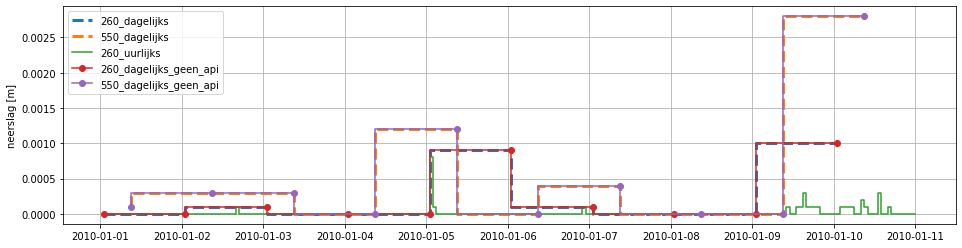

In [20]:
fig, ax = plt.subplots(figsize=(16,4))
ax.step(precip1.index, precip1.values, ls='--', lw=3, label=str(precip1.meta['station']) + '_dagelijks')
ax.step(precip2.index, precip2.values, ls='--', lw=3, label=str(precip2.meta['station']) + '_dagelijks')
ax.step(precip3.index, precip3.values, label=str(precip3.meta['station']) + '_uurlijks')
ax.step(precip4.index, precip4.values, marker='o', label=str(precip4.meta['station']) + '_dagelijks_geen_api')
ax.step(precip5.index, precip5.values, marker='o', label=str(precip5.meta['station']) + '_dagelijks_geen_api')
ax.legend()
ax.grid()
ax.set_ylabel('neerslag [m]');

The locations of the stations can be plotted onto a map, including the municipial borders.

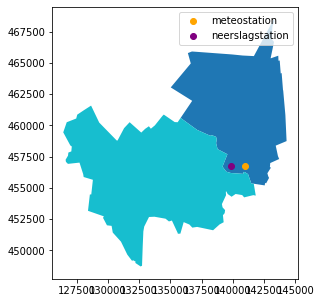

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
# plot locaties meetstations
ax.plot(precip1.x, precip1.y, marker='o', color='orange', label='meteostation', ls="none")
ax.plot(precip2.x, precip2.y, marker='o', color='purple', label='neerslagstation', ls='none')

# voeg gemeentegrenzen toe
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
gemeentegrenzen = gpd.read_file(geodata_url)
gemeentegrenzen.loc[gemeentegrenzen.statnaam.isin(['De Bilt', 'Utrecht'])].plot('statnaam',aspect=1, ax=ax, legend=True)
ax.legend();

## [Types of Reference Evaporation](#top)<a id=EvapRef></a>

KNMI provides the Makking reference evaporation (variable EV24). Hydropandas provides a posssibility to calculate three different types of reference evaporation from data of KNMI meteo stations:
- Penman
- Hargreaves
- Makkink (in the same way as KNMI)

These three types of reference evaporation are calculated the same way as described by [Allen et al. 1990](https://www.fao.org/3/x0490E/x0490e07.htm#solar%20radiation) and [STOWA rapport](https://edepot.wur.nl/163482). Be aware that the last report is written in Dutch and contains errors in the units.

The following variables from the KNMI are used for each reference evaporation type:
- Penman: average (TG), minimum (TN) and maximum (TX) temperature, de global radiation (Q), de windspeed (FG) en de relative humidity (PG).
- Hargreaves: average (TG), minimum (TN) and maximum (TX) temperature
- Makkink: average temperature (TG) and global radiation (Q)

### Comparison Makkink

Lets compare Hypdropandas Makkink verdamping evaporation with the EV24 Makkink verdamping of the KNMI. When Hydropandas Makkink evaporation is rounded (on 4 decimals), the estimate is the same as for the KNMI estimate.

In [22]:
ev24 = hpd.EvaporationObs.from_knmi(260).squeeze() # et_type='EV24' by default
makk = hpd.EvaporationObs.from_knmi(260, et_type='makkink').squeeze()

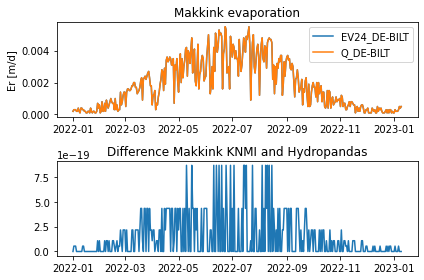

In [23]:
f, ax = plt.subplots(2, figsize=(6,4))
ax[0].plot(ev24, label=ev24.name)
ax[0].plot(makk.round(4), label=makk.name)
ax[0].set_ylabel('Er [m/d]')
ax[0].set_title('Makkink evaporation')
ax[0].legend()
ax[1].plot(ev24-makk.round(4))
ax[1].set_title('Difference Makkink KNMI and Hydropandas')
f.tight_layout()

### Comparison Penman, Makkink en Hargreaves
On average Penman gives a higher estimate for reference evaporation than Makkink (~0.55mm). This can be explained by the fact that Penman takes into account windspeed and Makkink ignores this proces. Hargreaves is a very simple way of estimation the evaporation, only taking into account temperature and extraterrestial radiation. Therefore it gives a lower estimate for the reference evporatoin compared to the two other methods (~-0.35mm wrt Makkink).

In [24]:
penm = hpd.EvaporationObs.from_knmi(260, et_type='penman').squeeze()
harg = hpd.EvaporationObs.from_knmi(260, et_type='hargreaves').squeeze()

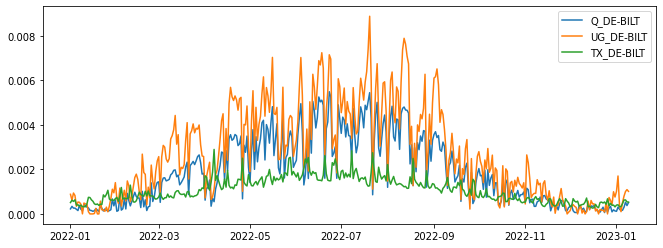

In [25]:
f, ax = plt.subplots(figsize=(11,4))
ax.plot(makk, label=makk.name)
ax.plot(penm, label=penm.name)
ax.plot(harg, label=harg.name)
ax.legend();

## [Spatial interpolate (Makkink) Evaporation?](#top)<a id=EvapInterp></a>

Does interpolation matter? There are ways to interpolate evaporation datasets. However currently the nearest station is always used for modeling. Does this give different results? First lets look spatially.

Get all stations where EV24 is measured

In [26]:
stns = io_knmi.get_stations(meteo_var='EV24').sort_index()

Collect all EV24 data ever measured by KNMI

In [27]:
tmin = '1900-01-01'
tmax = '2022-04-11'

# empty dataframe
df = pd.DataFrame(columns=stns.index) # index=pd.date_range(start=tmin, end=tmax, freq='H')

for stn in tqdm(stns.index):
    df_stn = hpd.MeteoObs.from_knmi(stn, meteo_var='EV24',
                                fill_missing_obs=False, 
                                startdate=tmin, enddate=tmax)
    df[stn] = df_stn

df

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:22<00:00,  1.53it/s]


,210,215,235,240,242,249,251,257,260,267,...,330,344,348,350,356,370,375,377,380,391
YYYYMMDD,,,,,,,,,,,,,,,,,,,,,
1987-03-26 01:00:00,0.0006,NaN,0.0006,NaN,NaN,NaN,NaN,NaN,0.0005,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0008,NaN,NaN,0.0010,NaN
1987-03-27 01:00:00,0.0016,NaN,0.0015,NaN,NaN,NaN,NaN,NaN,0.0016,NaN,...,NaN,NaN,0.0016,NaN,NaN,0.0017,NaN,NaN,0.0024,NaN
1987-03-28 01:00:00,0.0008,NaN,0.0007,NaN,NaN,NaN,NaN,NaN,0.0007,NaN,...,NaN,NaN,0.0007,NaN,NaN,0.0005,NaN,NaN,0.0008,NaN
1987-03-29 01:00:00,0.0013,NaN,0.0007,NaN,NaN,NaN,NaN,NaN,0.0010,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0013,NaN,NaN,0.0014,NaN
1987-03-30 01:00:00,0.0019,NaN,0.0021,NaN,NaN,NaN,NaN,NaN,0.0016,NaN,...,NaN,NaN,0.0017,NaN,NaN,0.0015,NaN,NaN,0.0018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-29 01:00:00,0.0023,0.0022,0.0020,0.0020,NaN,0.0015,0.0018,0.0014,0.0022,0.0021,...,0.0023,0.0026,0.0023,0.0018,0.0022,0.0024,0.0019,0.0025,0.0025,0.0023
2016-04-30 01:00:00,0.0023,0.0021,0.0025,0.0020,NaN,0.0022,0.0027,0.0022,0.0014,0.0021,...,0.0025,0.0021,0.0016,0.0014,0.0012,0.0015,0.0014,0.0010,0.0010,0.0009
2016-05-01 01:00:00,0.0023,0.0022,0.0029,0.0022,NaN,0.0021,0.0028,0.0026,0.0023,0.0026,...,0.0027,0.0025,0.0022,0.0021,0.0021,0.0022,0.0021,0.0009,0.0011,0.0015


Collect shape of NL (optional)

In [28]:
# import art_tools as at
# nl = at.shapes.nederland().boundary

According to the KNMI, thin plate spline is the best way to interpolate Makkink evaporation. Thats also how they provide the gridded Makkink evaporation : 

- [Evaporation Dataset - gridded daily Makkink evaporation for the Netherlands](https://dataplatform.knmi.nl/dataset/ev24-2)
- [Interpolation of Makkink evaporation in the
Netherlands - Paul Hiemstra and Raymond Sluiter (2011)](https://cdn.knmi.nl/knmi/pdf/bibliotheek/knmipubTR/TR327.pdf)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.42it/s]


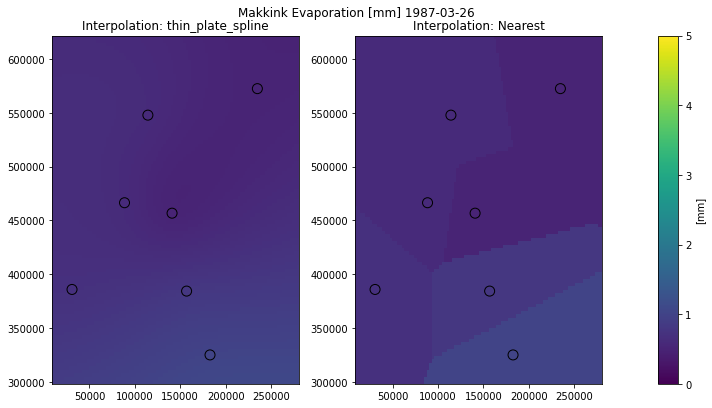

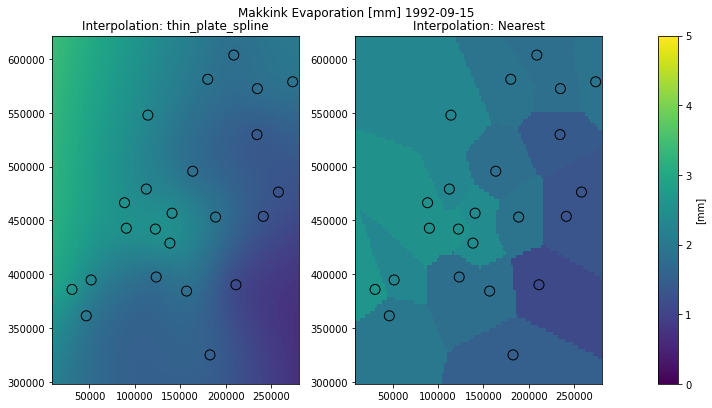

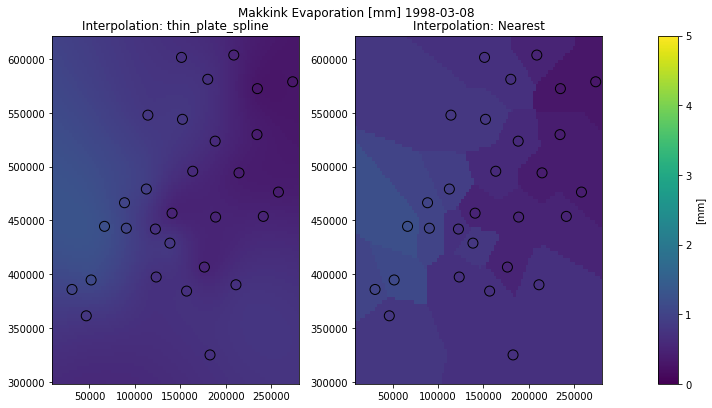

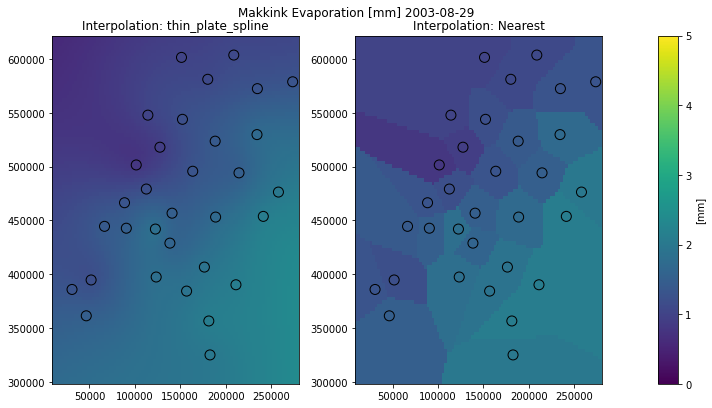

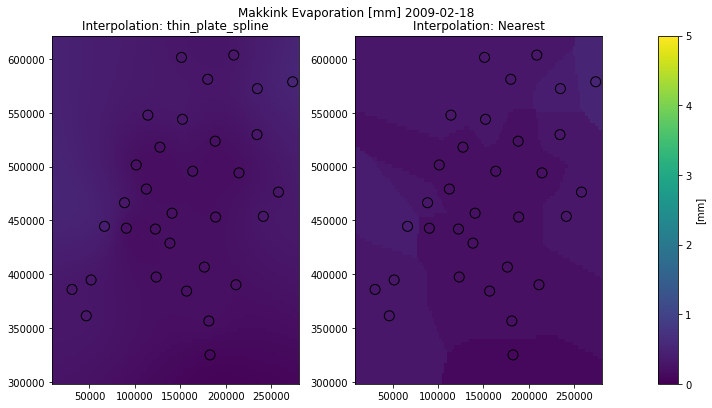

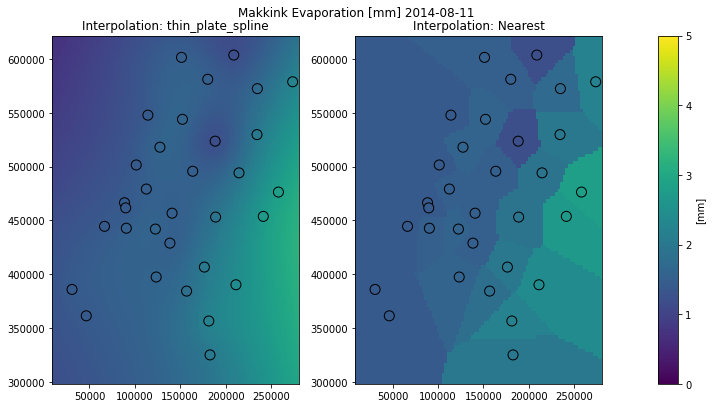

In [29]:
xy = stns.loc[df.columns, ['x', 'y']]

for idx in tqdm(df.index[0:len(df):2000]): 
    # get all stations with values for this date
    val = df.loc[idx].dropna() * 1000 #mm
    # get stations for this date
    coor = xy.loc[val.index].to_numpy()
    if len(val) < 3: # if there are less than 3 stations, thin plate spline does not work
        # options: linear, multiquadric, gaussian, 
         kernel = 'linear'

    else:
        kernel = 'thin_plate_spline' 
        # options:
        # 'inverse_quadratic', 'linear', 'multiquadric', 'gaussian', 
        # 'inverse_multiquadric', 'cubic', 'quintic', 'thin_plate_spline'

    # create an scipy interpolator
    rbf = RBFInterpolator(coor, val.to_numpy(), epsilon=1, kernel=kernel)
    
    nea = NearestNDInterpolator(coor, val.to_numpy())
    
    # interpolate on grid of the Netherlands
    grid = np.mgrid[10000:280000:100j, 300000:620000:100j]
    grid2 = grid.reshape(2, -1).T # interpolator only takes array [[x0, y0],
                                                                #  [x1, y1]]
    val_rbf = rbf.__call__(grid2).reshape(100, 100)
    val_nea = nea.__call__(grid2).reshape(100, 100)
    
    # create figure
    fig, ax = plt.subplot_mosaic('AAAABBBBC', figsize=(10,5.925))
    fig.suptitle(f'Makkink Evaporation [mm] {idx.date()}', y=0.95)
    vmin = 0
    vmax = 5

    ax['A'].set_title(f'Interpolation: {kernel}')
    ax['A'].pcolormesh(*grid, val_rbf, vmin=vmin, vmax=vmax)
    
    # nl.plot(ax=ax['A'], linewidth=1, color='w', zorder=1, alpha=0.4)

    ax['B'].set_title(f'Interpolation: Nearest')
    ax['B'].pcolormesh(*grid, val_nea, vmin=vmin, vmax=vmax)
    # nl.plot(ax=ax['B'], linewidth=1, color='w', zorder=1, alpha=0.4)
    ax['A'].scatter(*coor.T, c=val, s=100, ec='k', vmin=vmin, vmax=vmax)
    p = ax['B'].scatter(*coor.T, c=val, s=100, ec='k', vmin=vmin, vmax=vmax)
    cb = fig.colorbar(p, cax=ax['C'])
    cb.set_label('[mm]')
    fig.tight_layout()

The same method is implemented in Hydropandas and works both for one (EvaporationObs) or multiple coordinates (ObsCollection)

In [30]:
sd = '2022-01-01'
ed = '2022-04-14'
eti = hpd.EvaporationObs.from_xy((100000, 330000), startdate=sd, enddate=ed, method='interpolation') * 1000
eti

,EV24_100000_330000
2022-01-01,0.256626
2022-01-02,0.573079
2022-01-03,0.325246
2022-01-04,0.139717
2022-01-05,0.156186
...,...
2022-04-09,0.704787
2022-04-10,2.064715
2022-04-11,2.256866
2022-04-12,2.973555


In [31]:
etn = hpd.EvaporationObs.from_xy((100000, 330000), startdate=sd, enddate=ed, method='nearest') * 1000
etn

,EV24
2022-01-01 01:00:00,0.2
2022-01-02 01:00:00,0.5
2022-01-03 01:00:00,0.4
2022-01-04 01:00:00,0.2
2022-01-05 01:00:00,0.2
...,...
2022-04-10 01:00:00,2.5
2022-04-11 01:00:00,2.6
2022-04-12 01:00:00,2.8
2022-04-13 01:00:00,2.9


As can be seen, for one location the interpolation method is significantly slower. Lets see how the values compare for a time series.

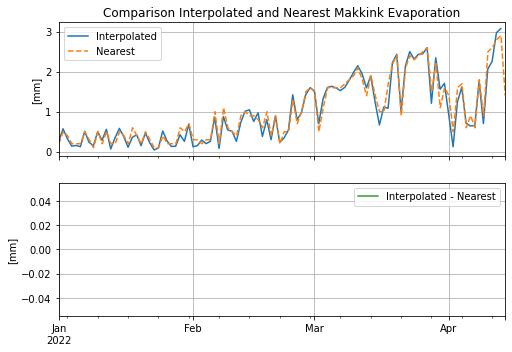

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)
eti.plot(ax=ax[0])
etn.plot(ax=ax[0], linestyle='--', color='C1')
ax[0].set_title('Comparison Interpolated and Nearest Makkink Evaporation')
ax[0].set_ylabel('[mm]')
ax[0].grid()
ax[0].legend(['Interpolated', 'Nearest'])

(eti.squeeze()-etn.squeeze()).plot(ax=ax[1], color='C2')
ax[1].set_ylabel('[mm]')
ax[1].grid()
ax[1].legend(['Interpolated - Nearest']);

The interpolated evaporation can also be collected for multiple points (using x and y in a list of DataFrame) in an ObsCollection

In [33]:
et1 = hpd.read_knmi(xy=[[110000, 330000],[110001, 330001]], meteo_vars=['EV24'], method='interpolation')
et1

,x,y,filename,source,station,meteo_var,obs
name,,,,,,,
EV24_110000_330000,110000,330000,,,interpolation thin plate sline,EV24,EvaporationObs EV24_110000_330000 -----metadat...
EV24_110001_330001,110001,330001,,,interpolation thin plate sline,EV24,EvaporationObs EV24_110001_330001 -----metadat...


In [34]:
locations = pd.DataFrame({'x':{'1':110000, '2':110001}, 'y':{'1':330000, '2':330001}})
et2 = hpd.read_knmi(locations, meteo_vars=['EV24'], method='interpolation')
et2

,x,y,filename,source,station,meteo_var,obs
name,,,,,,,
EV24_110000_330000,110000,330000,,,interpolation thin plate sline,EV24,EvaporationObs EV24_110000_330000 -----metadat...
EV24_110001_330001,110001,330001,,,interpolation thin plate sline,EV24,EvaporationObs EV24_110001_330001 -----metadat...


Let's see how much slower the method is when collecting data for all meteostation locations in the Netherlands.

In [35]:
# Comment Out due to Pytest time
# T1 = time.perf_counter()
# et3 = ObsCollection.from_knmi(stns, meteo_vars=['EV24'], method='interpolation', starts='2000')
# T2 = time.perf_counter()
# print(f'Time to collect interpolated observations: {T2-T1:0.1f}s')
# et4 = ObsCollection.from_knmi(stns, meteo_vars=['EV24'], method='nearest', starts='2000')
# T3 = time.perf_counter()
# print(f'Time to collect nearest observations: {T3-T2:0.1f}s')

Now the difference is not that significant anymore. Lets see how the time series compare at the locations of the meteostations

In [36]:
# Comment Out due to Pytest time
# fig, ax = plt.subplots(len(stns.index), figsize=(10,60), sharex=True, sharey=True)
# for i, (sidx, iidx, sidx) in enumerate(zip(stns.index, et3.index, et4.index)):
#     ii = et3.loc[iidx, 'obs'].squeeze() * 1000
#     ii.plot(ax=ax[i])
#     si = et4.loc[sidx, 'obs']['EV24'].squeeze() * 1000
#     si.plot(ax=ax[i], linestyle='--')
#     ax[i].grid()
#     ax[i].legend([iidx, sidx], title=f"MAE = {(si - ii).abs().mean():0.10f} [mm]")

Apparently the values at the locations of the stations are basically the same. Only differences are seen at locations where missing data is filled.